In [1]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [3]:
library(brms)
library(haven) # to load the SPSS .sav file
library(tidyverse) # needed for data manipulation.
library(RColorBrewer) # needed for some extra colours in one of the graphs
library(ggmcmc)
library(ggthemes)
library(ggridges)

# IMPORT VISUALIZATION LIBRARIES:
library(data.table)
library(ggplot2)
library(ggridges)
library(dplyr)
library(tidyr)
library(scales)
library(viridis)
library(bayesplot)
library(repr)

In [4]:
df <- read.table('uncon_v_con_shock_MR_ROI24_with_covariates2.txt',header = TRUE)

In [5]:
iterations <- 10000
chains <- 4
SCALE <- 1
ns <- iterations*chains/2


qVars = 'STATEmean,TRAITmean,TRAITdiff,STATEdiff'
EOI = 'Intercept,STATEmean,TRAITmean'
EOIq <- strsplit(qVars, '\\,')[[1]]
if(!('Intercept' %in% EOIq)) EOIq <- c('Intercept', EOIq)
EOIq <- intersect(strsplit(EOI, '\\,')[[1]], EOIq)
EOIq


dataTable <- df

# number of ROIs
nR <- nlevels(dataTable$ROI)

# number of sigfigs to show on the table
nfigs <- 4

head(dataTable)

[1] "Intercept" "STATEmean" "TRAITmean"

,Subj,ROI,Y,TRAITmean,TRAITdiff,STATEmean,STATEdiff
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,P00,vmPFC,-0.0544,-1.003,-0.0406,-1.2307,-0.1812
2,P00,PCC1,0.5107,-1.003,-0.0406,-1.2307,-0.1812
3,P00,PCC2,0.3733,-1.003,-0.0406,-1.2307,-0.1812
4,P00,rPAG,0.7424,-1.003,-0.0406,-1.2307,-0.1812
5,P00,lPAG,-0.0949,-1.003,-0.0406,-1.2307,-0.1812
6,P00,rvAI,0.2177,-1.003,-0.0406,-1.2307,-0.1812


# **1. Bayesian Multi-level modeling**

## **Model 1: Varying intercept model.**
ROIs will have varying intercepts and varying slopes for every independent variable.

$$Y \sim Student\_t(\nu,\mu_{s,r},\sigma^{2}_{\epsilon})$$  
$$\mu_{s,r} = \alpha + \alpha_{SUB} + \alpha_{ROI} + \beta_{TM}TM + \beta_{TD}TD + \beta_{SM}SM + \beta_{SD}SD + \epsilon$$

## **Priors**
$$\alpha \sim Student\_t(3,0,10)$$
$$\alpha_{SUB} \sim Student\_t(\nu_{SUB},0,\sigma_{SUB})$$
$$\sigma_{SUB} \sim Student\_t(3,0,10)$$
$$\nu_{SUB} \sim \Gamma(3.325,0.1)$$
$$\alpha_{ROI} \sim Student\_t(\nu_{ROI},0,\sigma_{ROI})$$
$$\sigma_{ROI} \sim Student\_t(3,0,10)$$
$$\nu_{ROI} \sim \Gamma(3.325,0.1)$$
$$\beta_{TM} \sim Student\_t(3,0,10)$$
$$\beta_{TD} \sim Student\_t(3,0,10)$$
$$\beta_{SM} \sim Student\_t(3,0,10)$$
$$\beta_{SD} \sim Student\_t(3,0,10)$$

$$\nu \sim \Gamma(3.325,0.1)$$
$$\sigma_{\epsilon} \sim Student\_t(3,0,10)$$

Where,  
TM: Trait mean  
TD: Triat difference  
SM: State mean  
SD: State difference  
BPD: button press difference  


In [6]:
mod = '1 + TRAITmean + TRAITdiff + STATEmean + STATEdiff'
modelForm = paste('Y ~',mod,'+ (1 | gr(Subj, dist= "student")) + (1| gr(ROI, dist="student"))')
priorRBA <- get_prior(formula = modelForm,data=df,family = 'student')
priorRBA$prior[2:6] <- "student_t(3,0,10)"
priorRBA$prior[7:8] <- "gamma(3.325,0.1)"
priorRBA$prior[10] <- "gamma(3.325,0.1)"
priorRBA

,prior,class,coef,group,resp,dpar,nlpar,bound
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,,b,,,,,,
2,"student_t(3,0,10)",b,STATEdiff,,,,,
3,"student_t(3,0,10)",b,STATEmean,,,,,
4,"student_t(3,0,10)",b,TRAITdiff,,,,,
5,"student_t(3,0,10)",b,TRAITmean,,,,,
6,"student_t(3,0,10)",df,,ROI,,,,
7,"gamma(3.325,0.1)",df,,Subj,,,,
8,"gamma(3.325,0.1)",Intercept,,,,,,
9,"gamma(2, 0.1)",nu,,,,,,


In [7]:
mod1 <- brm(modelForm,
          data=dataTable,
          chains = chains,
          family = 'student',
          inits=0, iter=iterations, 
          control = list(adapt_delta = 0.99, max_treedepth = 15))

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL '13394df63a158c2ca5863ec2939d35d1' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 281.25 seconds (Warm-up)
Chain 1:                516.28 seconds (Sampling)


## **Model 2: Varying intercept and varying slope model.**
ROIs will have varying intercepts and varying slopes for every independent variable.

$$Y \sim Student\_t(\nu,\mu_{s,r},\sigma^{2}_{\epsilon})$$  
$$\mu_{s,r} = \alpha + \alpha_{SUB} + \alpha_{ROI} + (\beta_{TM}+\beta_{ROI_{TM}})*TM + (\beta_{TD}+\beta_{ROI_{TD}})*TD + (\beta_{SM}+\beta_{ROI_{SM}})*SM + (\beta_{SD}+\beta_{ROI_{SD}})*SD + \epsilon$$

## **Priors**
$$\alpha \sim Student\_t(3,0,10)$$
$$\alpha_{SUB} \sim Student\_t(\nu_{SUB},0,\sigma_{SUB})$$
$$\sigma_{SUB} \sim Student\_t(3,0,10)$$
$$\nu_{SUB} \sim \Gamma(3.325,0.1)$$
$$\alpha_{ROI} \sim Student\_t(\nu_{ROI},0,\sigma_{ROI})$$
$$\sigma_{ROI} \sim Student\_t(3,0,10)$$
$$\nu_{ROI} \sim \Gamma(3.325,0.1)$$
$$\beta_{TM} \sim Student\_t(3,0,10)$$
$$\beta_{TD} \sim Student\_t(3,0,10)$$
$$\beta_{SM} \sim Student\_t(3,0,10)$$
$$\beta_{SD} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{TM}} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{TD}} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{SM}} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{SD}} \sim Student\_t(3,0,10)$$

$$\nu \sim \Gamma(3.325,0.1)$$
$$\sigma_{\epsilon} \sim Student\_t(3,0,10)$$

Where,  
TM: Trait mean  
TD: Triat difference  
SM: State mean  
SD: State difference  
BPD: button press difference  


In [9]:
mod = '1 + STATEmean + TRAITmean + STATEdiff + TRAITdiff'
modelForm = paste('Y ~',mod,'+ (1 | gr(Subj, dist= "student")) + (',mod,'| gr(ROI, dist="student"))')
priorRBA <- get_prior(formula = modelForm,data=df,family = 'student')
priorRBA$prior[2:6] <- "student_t(3,0,10)"
priorRBA$prior[9:10] <- "gamma(3.325,0.1)"
priorRBA$prior[12] <- "gamma(3.325,0.1)"
priorRBA

,prior,class,coef,group,resp,dpar,nlpar,bound
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,,b,,,,,,
2,"student_t(3,0,10)",b,STATEdiff,,,,,
3,"student_t(3,0,10)",b,STATEmean,,,,,
4,"student_t(3,0,10)",b,TRAITdiff,,,,,
5,"student_t(3,0,10)",b,TRAITmean,,,,,
6,"student_t(3,0,10)",cor,,,,,,
7,,cor,,ROI,,,,
8,"gamma(2, 0.1)",df,,ROI,,,,
9,"gamma(3.325,0.1)",df,,Subj,,,,


In [10]:
mod2 <- brm(modelForm,
          data=dataTable,
          chains = chains,
          family = 'student',
          inits=0, iter=iterations, 
          control = list(adapt_delta = 0.99, max_treedepth = 15))

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL '27088e9a79127bc901d4f3ba464ae163' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 730.98 seconds (Warm-up)
Chain 1:                1794.6 seconds (Sampling)


## **Leave one out cross-validation & model comparison**

In [11]:
mod1 <- add_criterion(mod1,c("loo","waic","bayes_R2"))
mod2 <- add_criterion(mod2,c("loo","waic","bayes_R2"))

In [12]:
# Compare both models
comparison_table <- loo_compare(mod1,mod2)
comparison_table

,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
mod1,0.0000000,0.000000,-528.5912,37.90407,75.18064,1.57177,1057.182,75.80814
mod2,-0.3433833,2.603216,-528.9346,37.86514,91.17014,1.99515,1057.869,75.73028


## **Goodness of fit**

In [13]:
R2_table <- data.frame(sapply(list(mod1,mod2), function(x) round(median(x$criteria$bayes_R2)*100, 2)),row.names = c('mod1','mod2'))
names(R2_table) <- "Bayes R2"
R2_table                        

,Bayes R2
,<dbl>
mod1,16.52
mod2,17.41


## **Posterior Predictive Check**

Warning message:
“Removed 925 rows containing non-finite values (stat_density).”
Warning message:
“Removed 8 rows containing non-finite values (stat_density).”


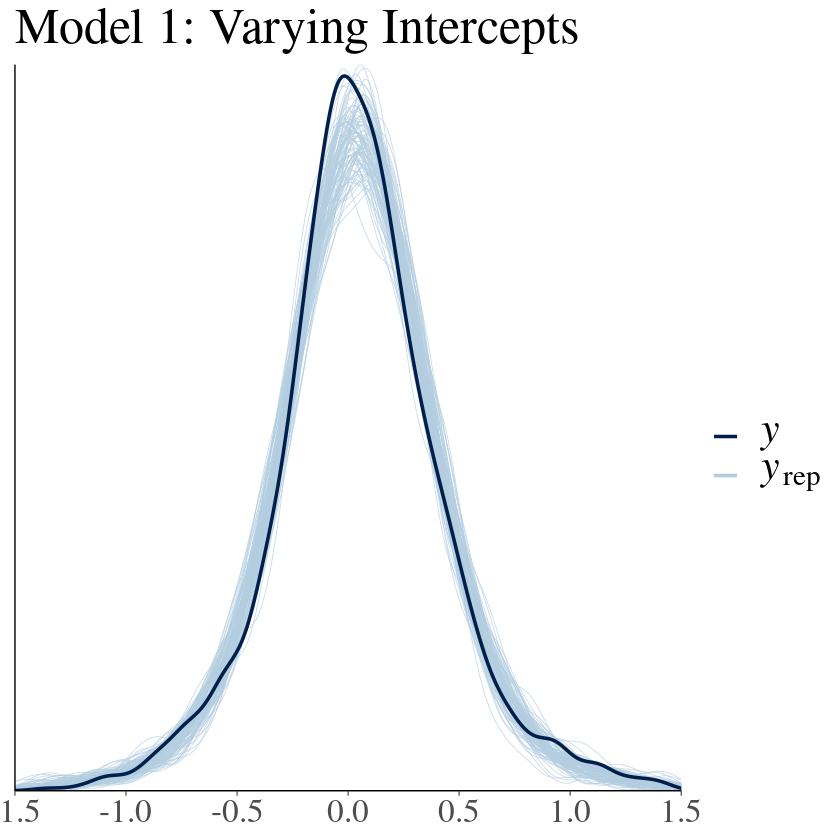

In [14]:
pp_plot_mod1 = pp_check(mod1,nsamples = 100)
pp_plot_mod1 + xlim(-1.5,1.5) + theme(text = element_text(size=25),legend.text=element_text(size=25)) + ggtitle("Model 1: Varying Intercepts")

Warning message:
“Removed 841 rows containing non-finite values (stat_density).”
Warning message:
“Removed 8 rows containing non-finite values (stat_density).”


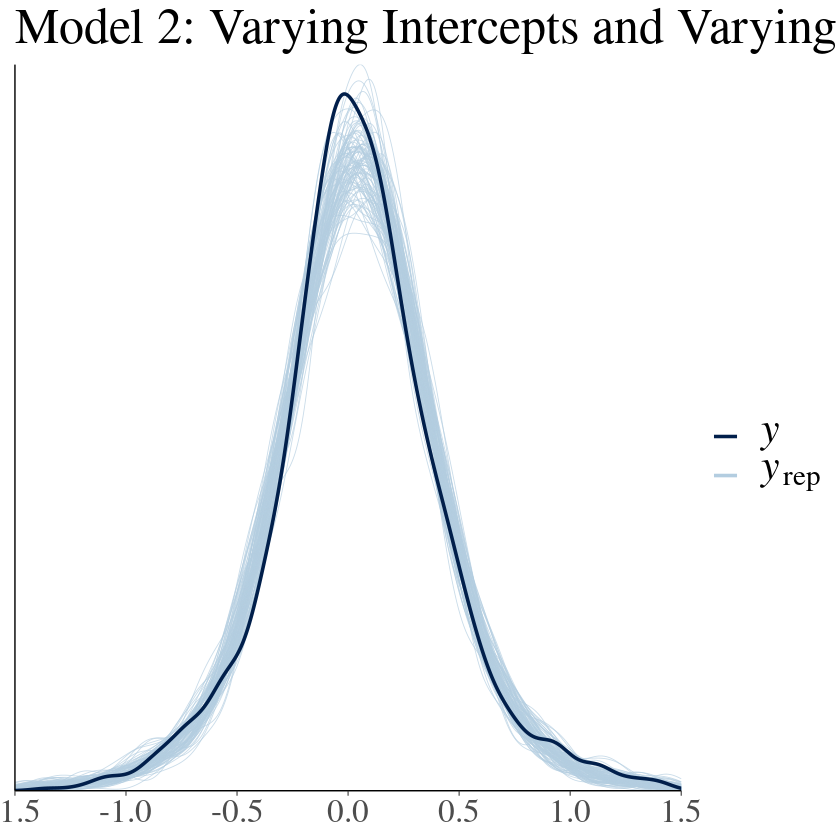

In [15]:
pp_plot_mod2 = pp_check(mod2,nsamples = 100)
pp_plot_mod2 + xlim(-1.5,1.5) + theme(text = element_text(size=25),legend.text=element_text(size=25)) + ggtitle("Model 2: Varying Intercepts and Varying Slopes")

In [1]:
options(repr.plot.width=15,repr.plot.height=50)
mcmc_rhat(rhat(mod2)) + yaxis_text(hjust=1)

ERROR: Error in mcmc_rhat(rhat(mod2)): could not find function "mcmc_rhat"
